## 이미지에서 cactus 여부 확인

In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [ ]:
train_dir = "train/"
test_dir = "test/"
train_df = pd.read_csv('train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


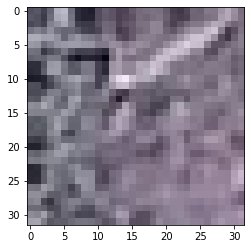

In [ ]:
im = cv2.imread("train/01e30c0ba6e91343a12d2126fcafc0dd.jpg")
plt.imshow(im)

VGG16Net을 사용

In [ ]:
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(32, 32, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg16_net.trainable = False
vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
model = Sequential()
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
X_tr = []
Y_tr = []
imges = train_df['id'].values
for img_id in tqdm_notebook(imges):
    X_tr.append(cv2.imread(train_dir + img_id))    
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  
X_tr = np.asarray(X_tr)
X_tr = X_tr.astype('float32')
X_tr /= 255
Y_tr = np.asarray(Y_tr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/17500 [00:00<?, ?it/s]

In [ ]:
batch_size = 32
nb_epoch = 50
epochs=50

In [ ]:
%%time
# Train model
history = model.fit(X_tr, Y_tr,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.1,
              shuffle=True,
              verbose=2)

Epoch 1/50
493/493 - 10s - loss: 0.3464 - accuracy: 0.8514 - val_loss: 0.3045 - val_accuracy: 0.9023 - 10s/epoch - 21ms/step
Epoch 2/50
493/493 - 10s - loss: 0.3147 - accuracy: 0.8729 - val_loss: 0.2767 - val_accuracy: 0.9223 - 10s/epoch - 21ms/step
Epoch 3/50
493/493 - 9s - loss: 0.2878 - accuracy: 0.8903 - val_loss: 0.2544 - val_accuracy: 0.9286 - 9s/epoch - 19ms/step
Epoch 4/50
493/493 - 9s - loss: 0.2665 - accuracy: 0.9008 - val_loss: 0.2364 - val_accuracy: 0.9337 - 9s/epoch - 19ms/step
Epoch 5/50
493/493 - 9s - loss: 0.2470 - accuracy: 0.9113 - val_loss: 0.2208 - val_accuracy: 0.9400 - 9s/epoch - 19ms/step
Epoch 6/50
493/493 - 10s - loss: 0.2315 - accuracy: 0.9183 - val_loss: 0.2088 - val_accuracy: 0.9429 - 10s/epoch - 19ms/step
Epoch 7/50
493/493 - 9s - loss: 0.2180 - accuracy: 0.9265 - val_loss: 0.1978 - val_accuracy: 0.9451 - 9s/epoch - 19ms/step
Epoch 8/50
493/493 - 10s - loss: 0.2101 - accuracy: 0.9264 - val_loss: 0.1890 - val_accuracy: 0.9486 - 10s/epoch - 19ms/step
Epoch 9/

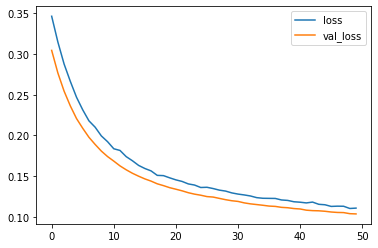

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()


In [ ]:
%%time
X_tst = []
Test_imgs = []
for img_id in tqdm_notebook(os.listdir(test_dir)):
    X_tst.append(cv2.imread(test_dir + img_id))     
    Test_imgs.append(img_id)
X_tst = np.asarray(X_tst)
X_tst = X_tst.astype('float32')
X_tst /= 255

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 293 ms, sys: 157 ms, total: 450 ms
Wall time: 450 ms


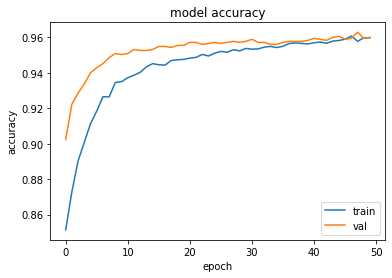

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()